<a href="https://colab.research.google.com/github/zuzannazak/PhD2022Bialowieza/blob/main/%F0%9F%92%96projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#💖***Projekt z ekonometrii***💖

**Authors:**

Wiktoria Rakowska

Monika Wesołowska

Zuzanna Żak


**Data:**
*   Aggregated in https://github.com/zuzannazak/random-files-i-need-sometimes/blob/main/bialowieza.xls :
  *   Chrzty, śluby i zgony w parafii prawosłwanej św. Mikołaja Cudotwórcy w Białowieży https://github.com/pbiecek/SmarterPoland_blog/tree/master/dane/Bialowieza/
  *   Population data for Białowieża, rural gmina, from Bank Danych Lokalnych
  *   Population data for Poland https://stat.gov.pl/obszary-tematyczne/ludnosc/ludnosc/struktura-ludnosci,16,1.html 
  *   Religious practices in Poland https://cbos.pl/SPISKOM.POL/2020/K_063_20.PDF 

# ***introduction***



*   Białowieża i trochę o historii miasta
*   Fajne dane urywajace się na 2012 (tutaj można wpleść też niektóre wykresy z sekcji visualization (zmienić kolejność bloków strzałkami i wrzucić je pomiędzy bloki tekstu)
*   Projekt - dokończenie tych danych, czyli predykcja dalszych małżeństw, chrztów i zgonów
*   Dodatkowe dane: dane na temat małżeństw, urodzeń i zgonów z gminy, populacja polski, saldo migracji
*   consideration: religijność w polsce, przewidujemy rejestr kościelny (cerkiewny) więc w przypadku spadku religijności można spodziewać się spadek tych wartości w rejestrze, nawet jeśli dane cywilne tego nie pokazują



# ***package import***

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ***data download***

In [2]:
#original Białowieża data
url_data = (r'https://raw.github.com/pbiecek/SmarterPoland_blog/master/dane/Bialowieza/bialowieza.xls')
df = pd.read_excel(url_data)

df.head()

,rok,chrzest,slub,zgon
0,1878,62.0,2.0,44.0
1,1879,77.0,14.0,38.0
2,1880,79.0,14.0,60.0
3,1881,NaN,NaN,NaN
4,1882,86.0,17.0,52.0


In [3]:
#aggregated data
url_data = (r'https://github.com/zuzannazak/random-files-i-need-sometimes/blob/49f2717618bf867b22213dd08ee8efd5ab565a1b/bialowieza.xls?raw=true')
df_aggregateddata = pd.read_excel(url_data)

df_aggregateddata.tail(10)

,rok,chrzest,slub,zgon,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
138,2016,NaN,NaN,NaN,11.0,-3.0,2205.0,38433.0,14.0,47.0,50.0,36.0,5.0
139,2017,NaN,NaN,NaN,5.0,83.0,2253.0,38434.0,10.0,45.0,49.0,37.0,5.0
140,2018,NaN,NaN,NaN,10.0,12.0,2199.0,38411.0,12.0,44.0,50.0,36.0,6.0
141,2019,NaN,NaN,NaN,13.0,-12.0,2191.0,38383.0,18.0,47.0,47.0,36.0,6.0
142,2020,NaN,NaN,NaN,7.0,-14.0,2130.0,NaN,8.0,44.0,47.0,37.0,7.0
143,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_aggregateddata.drop(df.tail(5).index,inplace=True)

#***data visualisation*** 

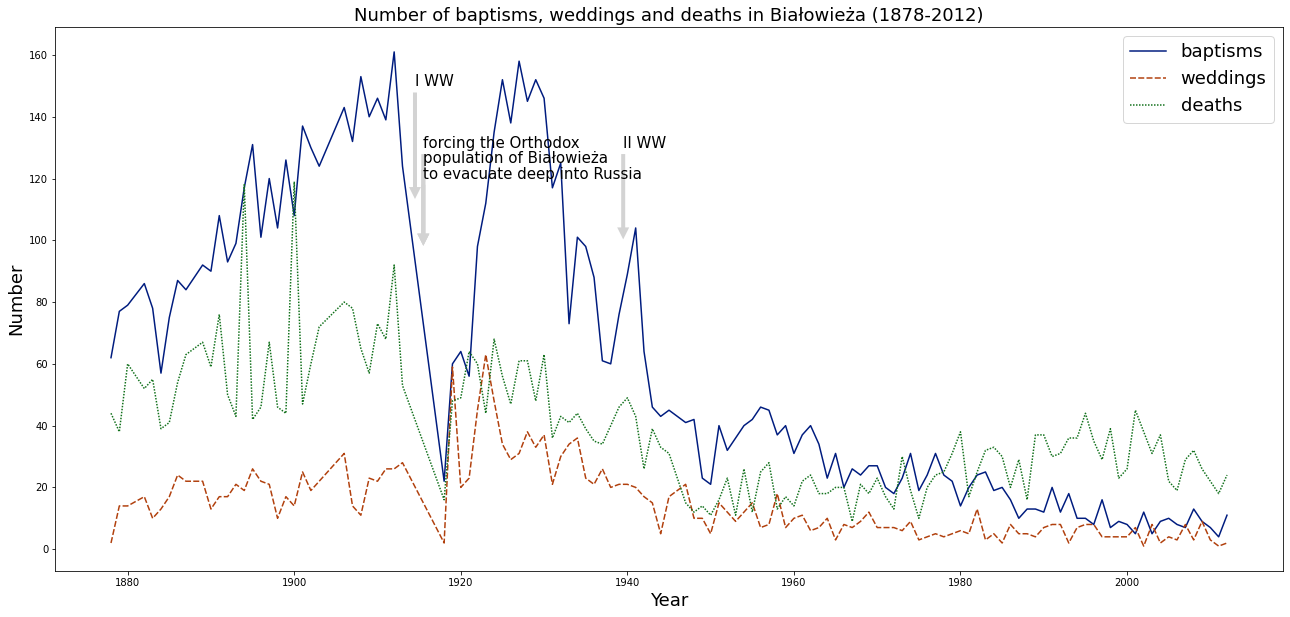

In [8]:
url_data = (r'https://github.com/zuzannazak/PhD2022Bialowieza/blob/main/bialowieza_visualisation.xlsx?raw=true')
DF = pd.read_excel(url_data)
plt.figure(figsize=(22,10))
plt.title("Number of baptisms, weddings and deaths in Białowieża (1878-2012)", fontsize=18)
g=sns.lineplot(x=DF["rok"], y=DF["liczba odnotowanych"], hue=DF["zdarzenie"], style=DF["zdarzenie"], palette='dark', legend=True, ci=True)

plt.annotate('I WW', xy=(1914.5, 113), xytext=(1914.5, 150), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('II WW', xy=(1939.5, 100), xytext=(1939.5, 130), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('forcing the Orthodox', xy=(1915.5, 98), xytext=(1915.5, 130), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('population of Białowieża', xy=(1915.5, 98), xytext=(1915.5, 125), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.annotate('to evacuate deep into Russia', xy=(1915.5, 98), xytext=(1915.5, 120), fontsize=15, arrowprops=dict(facecolor='lightgrey', shrink=0.01, linewidth=0))
plt.ylabel('Number', fontsize=18)
plt.xlabel('Year',fontsize=18 )
plt.legend(fontsize=18 )

sns.set_style("whitegrid")
#plt.style.use('fivethirtyeight')
sns.set_theme()



Text(0.5, 0, 'Event')

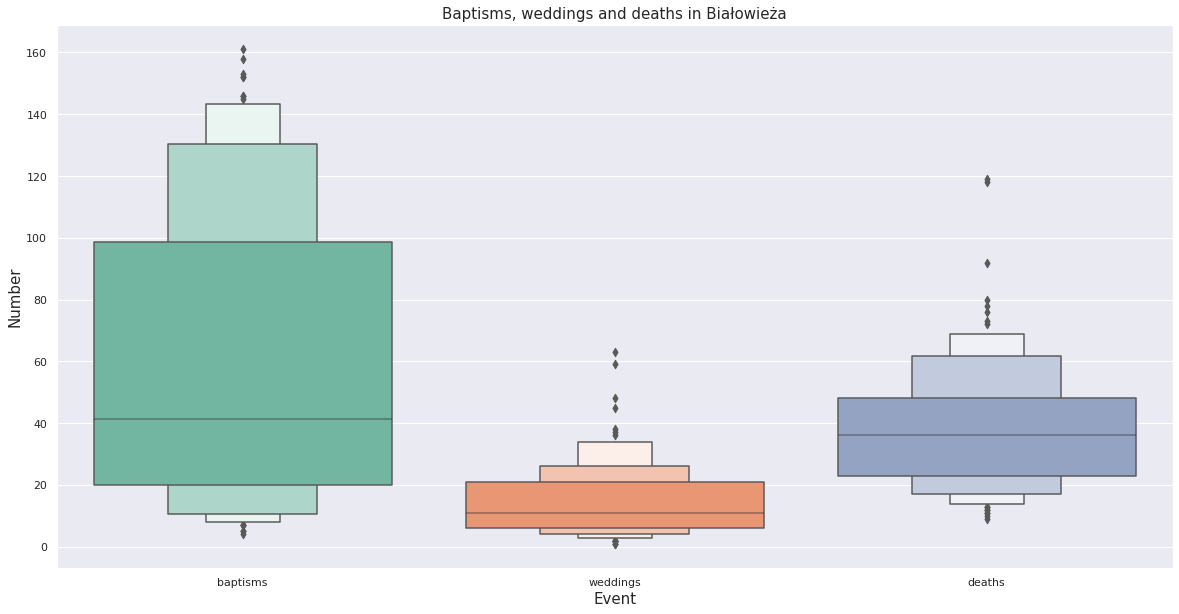

In [9]:
plt.figure(figsize=(20, 10))
sns.boxenplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and deaths in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )


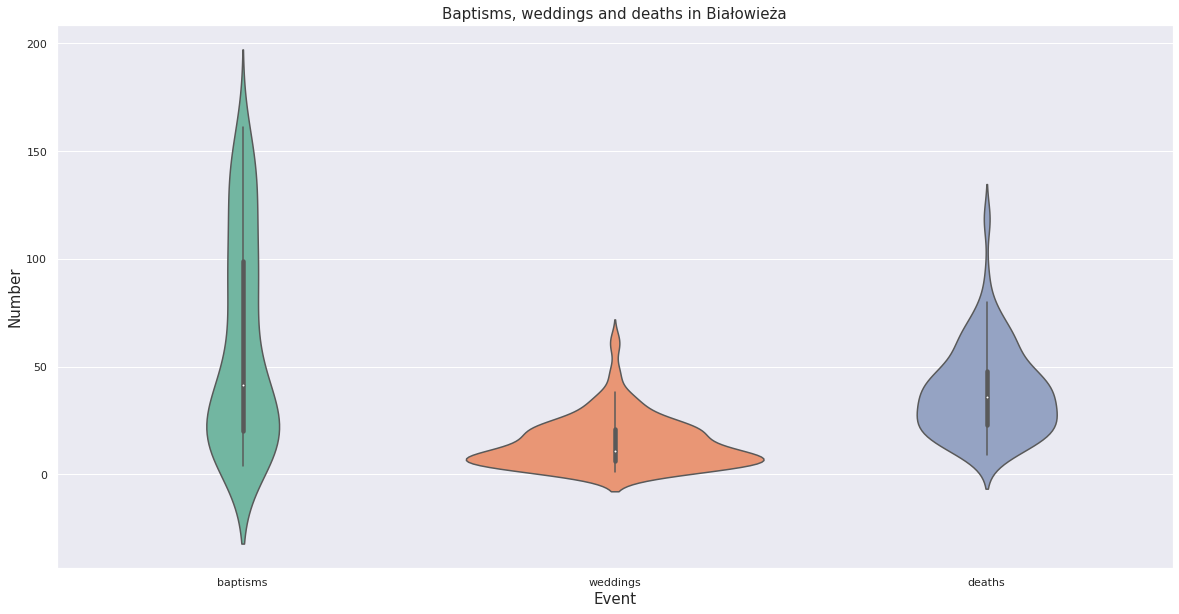

In [10]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and deaths in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )

plt.show()

Text(0.5, 0, 'Event')

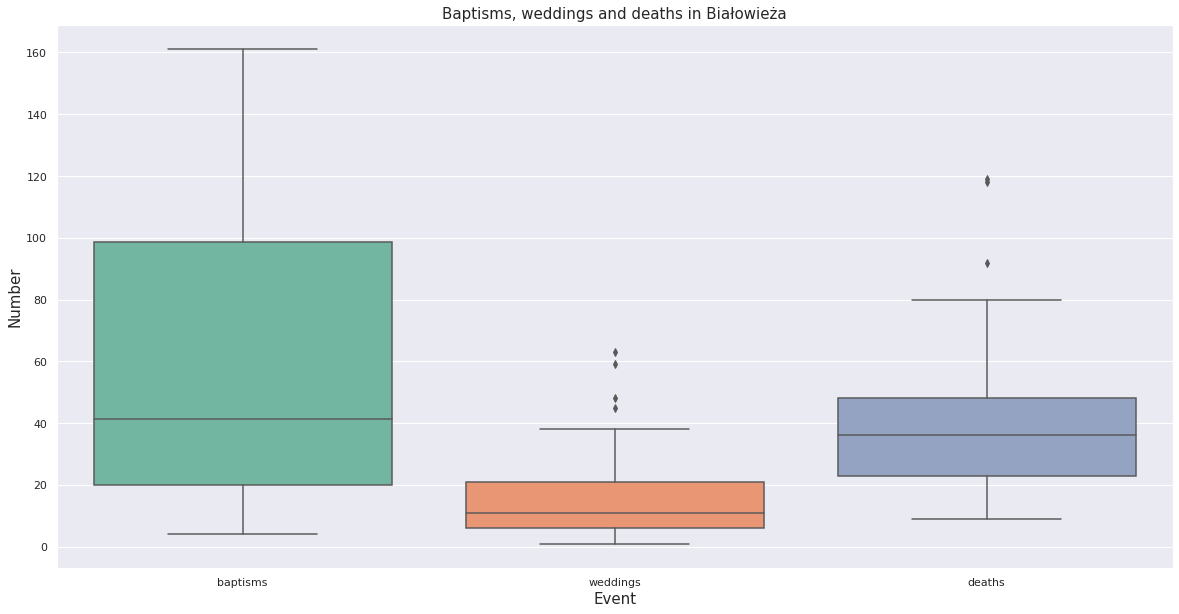

In [11]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=DF["zdarzenie"], y=DF["liczba odnotowanych"], palette="Set2")
plt.title("Baptisms, weddings and deaths in Białowieża",fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xlabel('Event',fontsize=15 )

# ***analysis***

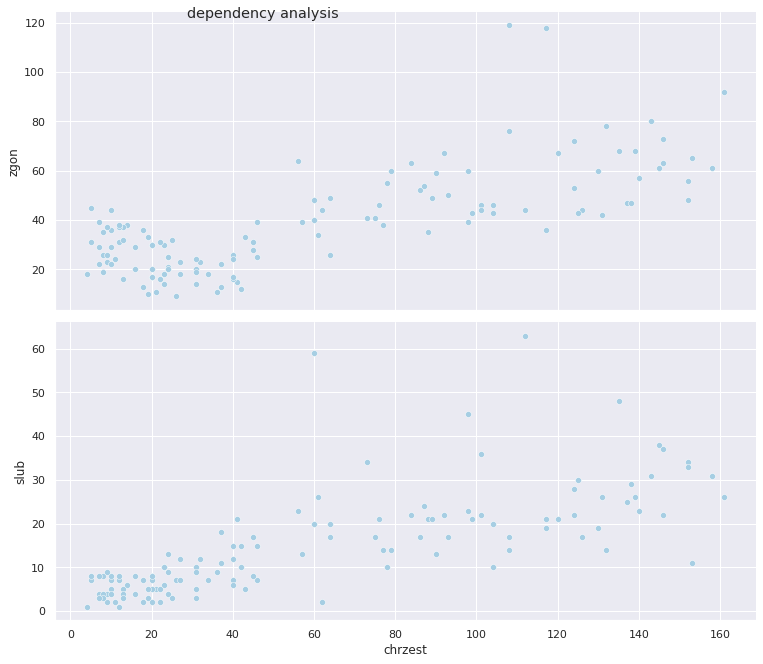

In [ ]:
g=sns.pairplot(df, x_vars=["chrzest"], y_vars=["zgon", "slub"])
g.fig.set_size_inches(15,10)
g.fig.suptitle("dependency analysis")
sns.set_palette(sns.color_palette("Paired"))

## **correlation**

In [ ]:
#correlation
korel = df_aggregateddata.corr()
df_aggregateddata.corr()

,rok,chrzest,slub,zgon,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
rok,1.000000,-0.790225,-0.548468,-0.625626,-0.249509,0.121983,-0.987842,0.917007,-0.631400,-0.516797,-0.933478,0.917846,0.926907
chrzest,-0.790225,1.000000,0.723879,0.734958,0.166678,0.020184,0.367164,-0.851805,0.530261,0.096466,0.206220,-0.282586,-0.076208
slub,-0.548468,0.723879,1.000000,0.494156,0.250358,-0.332055,0.219584,-0.567625,-0.034056,0.216313,-0.357950,0.486897,-0.210090
zgon,-0.625626,0.734958,0.494156,1.000000,-0.327423,0.093535,0.407990,0.627110,0.009932,0.798494,-0.528198,0.219169,-0.476537
GUS - Małżeństwa zawarte w gminie,-0.249509,0.166678,0.250358,-0.327423,1.000000,-0.595898,0.252977,-0.194074,0.461549,-0.148913,0.299588,-0.315667,-0.286668
GUS - saldo migracji ogółem,0.121983,0.020184,-0.332055,0.093535,-0.595898,1.000000,-0.126800,0.316217,-0.293864,-0.016248,-0.134057,0.228395,0.045927
GUS - Ludność w gminie,-0.987842,0.367164,0.219584,0.407990,0.252977,-0.126800,1.000000,-0.681793,0.645038,0.521026,0.930701,-0.924322,-0.925620
GUS - Ludność w Polsce stan w dniu 31.XII (tys.),0.917007,-0.851805,-0.567625,0.627110,-0.194074,0.316217,-0.681793,1.000000,-0.245313,-0.227350,-0.818915,0.870127,0.821922
GUS - urodzenia żywe w gminie,-0.631400,0.530261,-0.034056,0.009932,0.461549,-0.293864,0.645038,-0.245313,1.000000,0.376193,0.469521,-0.455743,-0.442095
GUS - zgony w gminie,-0.516797,0.096466,0.216313,0.798494,-0.148913,-0.016248,0.521026,-0.227350,0.376193,1.000000,0.197993,-0.291389,-0.345466


## **filling in data gaps**

In [ ]:
#data gaps
df_aggregateddata.isnull().sum()


rok                                                    0
chrzest                                               22
slub                                                  22
zgon                                                  22
GUS - Małżeństwa zawarte w gminie                    122
GUS - saldo migracji ogółem                          122
GUS - Ludność w gminie                               122
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)     78
GUS - urodzenia żywe w gminie                        122
GUS - zgony w gminie                                 122
CBOS - % Wierzący i praktykujący regularnie          124
CBOS - % Wierzący i praktykujący nieregularnie       124
CBOS - % Niewierzący i niepraktykujący               124
dtype: int64

In [ ]:
CORREL = df_aggregateddata.corr()
CORREL['chrzest'].to_frame().sort_values('chrzest')
CORREL = df_aggregateddata.corr()
CORREL['slub'].to_frame().sort_values('slub')
CORREL = df_aggregateddata.corr()
CORREL['zgon'].to_frame().sort_values('zgon')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Małżeństwa zawarte w gminie'].to_frame().sort_values('GUS - Małżeństwa zawarte w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - saldo migracji ogółem'].to_frame().sort_values('GUS - saldo migracji ogółem')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Ludność w gminie'].to_frame().sort_values('GUS - Ludność w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].to_frame().sort_values('GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)')
CORREL = df_aggregateddata.corr()
CORREL['GUS - urodzenia żywe w gminie'].to_frame().sort_values('GUS - urodzenia żywe w gminie')
CORREL = df_aggregateddata.corr()
CORREL['GUS - zgony w gminie'].to_frame().sort_values('GUS - zgony w gminie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Wierzący i praktykujący regularnie'].to_frame().sort_values('CBOS - % Wierzący i praktykujący regularnie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Wierzący i praktykujący nieregularnie'].to_frame().sort_values('CBOS - % Wierzący i praktykujący nieregularnie')
CORREL = df_aggregateddata.corr()
CORREL['CBOS - % Niewierzący i niepraktykujący'].to_frame().sort_values('CBOS - % Niewierzący i niepraktykujący')

,CBOS - % Niewierzący i niepraktykujący
CBOS - % Wierzący i praktykujący regularnie,-0.942047
GUS - Ludność w gminie,-0.925620
zgon,-0.476537
GUS - urodzenia żywe w gminie,-0.442095
GUS - zgony w gminie,-0.345466
GUS - Małżeństwa zawarte w gminie,-0.286668
slub,-0.210090
chrzest,-0.076208
GUS - saldo migracji ogółem,0.045927
GUS - Ludność w Polsce stan w dniu 31.XII (tys.),0.821922


In [ ]:
df_aggregateddata['chrzest'] = df_aggregateddata.groupby('zgon')['chrzest'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['chrzest'].fillna(method='ffill', inplace=True)  
df_aggregateddata['zgon'] = df_aggregateddata.groupby('GUS - zgony w gminie')['zgon'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['zgon'].fillna(method='ffill', inplace=True)  
df_aggregateddata['slub'] = df_aggregateddata.groupby('chrzest')['slub'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['slub'].fillna(method='ffill', inplace=True)  
df_aggregateddata['GUS - Małżeństwa zawarte w gminie'] = df_aggregateddata.groupby('GUS - urodzenia żywe w gminie')['GUS - Małżeństwa zawarte w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Małżeństwa zawarte w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - saldo migracji ogółem'] = df_aggregateddata.groupby('GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)')['GUS - saldo migracji ogółem'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - saldo migracji ogółem'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - Ludność w gminie'] = df_aggregateddata.groupby('CBOS - % Wierzący i praktykujący regularnie')['GUS - Ludność w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Ludność w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'] = df_aggregateddata.groupby('rok')['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - urodzenia żywe w gminie'] = df_aggregateddata.groupby('GUS - Ludność w gminie')['GUS - urodzenia żywe w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - urodzenia żywe w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['GUS - zgony w gminie'] = df_aggregateddata.groupby('zgon')['GUS - zgony w gminie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['GUS - zgony w gminie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Wierzący i praktykujący regularnie'] = df_aggregateddata.groupby('GUS - Ludność w gminie')['CBOS - % Wierzący i praktykujący regularnie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Wierzący i praktykujący regularnie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Wierzący i praktykujący nieregularnie'] = df_aggregateddata.groupby('CBOS - % Niewierzący i niepraktykujący')['CBOS - % Wierzący i praktykujący nieregularnie'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Wierzący i praktykujący nieregularnie'].fillna(method='ffill', inplace=True) 
df_aggregateddata['CBOS - % Niewierzący i niepraktykujący'] = df_aggregateddata.groupby('rok')['CBOS - % Niewierzący i niepraktykujący'].apply(lambda x: x.ffill().bfill())
df_aggregateddata['CBOS - % Niewierzący i niepraktykujący'].fillna(method='ffill', inplace=True) 


df_aggregateddata.to_excel(r'fillna_data_bialowieza.xlsx', index = False)

In [ ]:
df_aggregateddata.isnull().sum()

rok                                                    0
chrzest                                                0
slub                                                   0
zgon                                                 117
GUS - Małżeństwa zawarte w gminie                    117
GUS - saldo migracji ogółem                          117
GUS - Ludność w gminie                               119
GUS - Ludność  w Polsce stan w dniu 31.XII (tys.)     72
GUS - urodzenia żywe w gminie                        119
GUS - zgony w gminie                                 117
CBOS - % Wierzący i praktykujący regularnie          119
CBOS - % Wierzący i praktykujący nieregularnie       119
CBOS - % Niewierzący i niepraktykujący               119
dtype: int64

In [ ]:
df_aggregateddata.dropna(inplace=True)

In [ ]:
df_aggregateddata

,rok,chrzest,slub,zgon,GUS - Małżeństwa zawarte w gminie,GUS - saldo migracji ogółem,GUS - Ludność w gminie,GUS - Ludność w Polsce stan w dniu 31.XII (tys.),GUS - urodzenia żywe w gminie,GUS - zgony w gminie,CBOS - % Wierzący i praktykujący regularnie,CBOS - % Wierzący i praktykujący nieregularnie,CBOS - % Niewierzący i niepraktykujący
119,1997,16.0,4.0,29.0,14.0,-9.0,2938.0,38290.0,39.0,50.0,56.0,32.0,3.0
120,1998,7.0,4.0,39.0,9.0,5.0,2919.0,38277.0,20.0,55.0,57.0,32.0,3.0
121,1999,9.0,4.0,23.0,12.0,10.0,2787.0,38263.0,21.0,43.0,58.0,32.0,3.0
122,2000,8.0,4.0,26.0,10.0,5.0,2697.0,38254.0,23.0,45.0,58.0,32.0,3.0
123,2001,5.0,7.0,45.0,13.0,-14.0,2747.0,38242.0,25.0,52.0,55.0,33.0,3.0
124,2002,12.0,1.0,38.0,10.0,4.0,2714.0,38219.0,11.0,53.0,56.0,32.0,3.0
125,2003,5.0,8.0,31.0,9.0,12.0,2687.0,38191.0,6.0,41.0,55.0,32.0,3.0
126,2004,9.0,2.0,37.0,6.0,22.0,2671.0,38174.0,18.0,60.0,56.0,31.0,3.0
127,2005,10.0,4.0,22.0,11.0,-3.0,2707.0,38157.0,18.0,34.0,58.0,32.0,3.0
128,2006,8.0,3.0,19.0,12.0,3.0,2664.0,38125.0,20.0,41.0,56.0,32.0,4.0


## **Regression**

In [ ]:
X = df_aggregateddata.iloc[:, df_aggregateddata.columns != "chrzest"]
Y = df_aggregateddata["chrzest"].values.reshape(-1,1)
linear_regressor = LinearRegression().fit(X, Y)
Y_pred = linear_regressor.predict(X)

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     2.758
Date:                Tue, 25 Jan 2022   Prob (F-statistic):             0.0517
Time:                        02:20:27   Log-Likelihood:                -36.499
No. Observations:                  24   AIC:                             99.00
Df Residuals:                      11   BIC:                             114.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

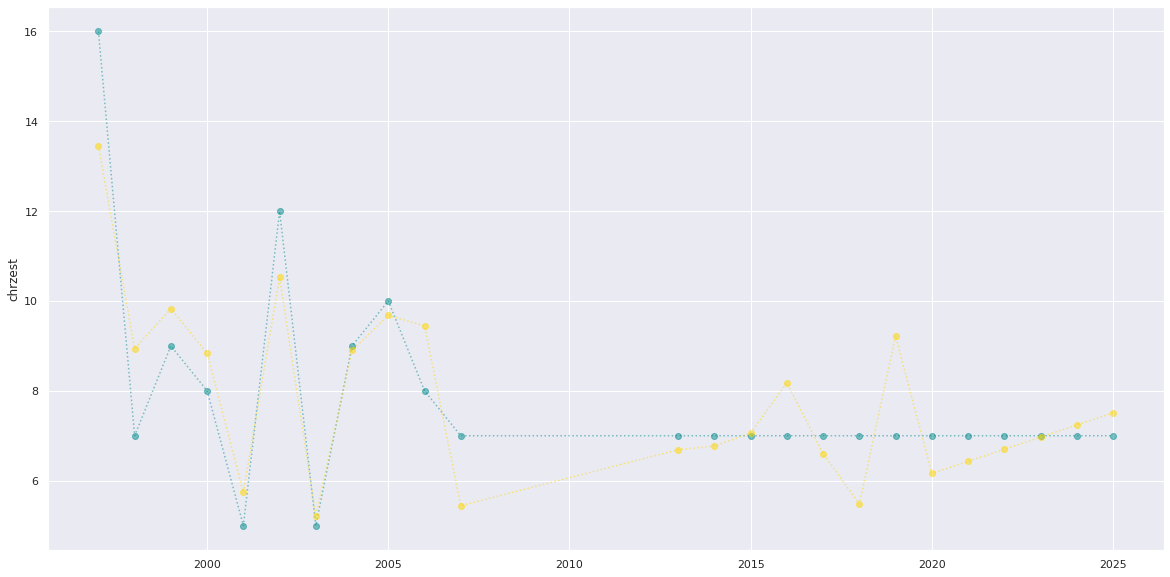

In [ ]:
df_aggregateddata['Y_pred'] = Y_pred
fig, ax = plt.subplots()
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["chrzest"],marker='o', color="darkcyan",alpha=0.5, linestyle='dotted')
ax.plot((df_aggregateddata["rok"]), df_aggregateddata["Y_pred"],marker='o', color="gold",alpha=0.5, linestyle='dotted')
ax.set_ylabel('chrzest')
fig.set_size_inches(20, 10)

## **SNN**

In [ ]:
X_SNN = df_aggregateddata.iloc[:, df_aggregateddata.columns != "chrzest"]
Y_SNN = df_aggregateddata["chrzest"].values.reshape(-1,1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
 X_SNN, Y_SNN, test_size=0.33, random_state=42)

In [ ]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.10, random_state=1)

In [ ]:
clf = MLPRegressor(solver='adam', learning_rate='adaptive', alpha=1e-5, activation='relu', hidden_layer_sizes=(5,5,5), random_state=2, max_iter=500, batch_size=62)

In [ ]:
clf.fit(X_train, Y_train.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:612: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  "Got `batch_size` less than 1 or larger than "


MLPRegressor(alpha=1e-05, batch_size=62, hidden_layer_sizes=(5, 5, 5),
             learning_rate='adaptive', max_iter=500, random_state=2)

In [ ]:
MSE = mean_squared_error(clf.predict(X_test), Y_test.flatten())
RMSE = np.sqrt(MSE)
RMSE

9.1748440406582

In [ ]:
mean_absolute_percentage_error(clf.predict(X_test), Y_test.flatten())

39.54248442548199

In [ ]:
R_kw = r2_score(Y_test.flatten(), clf.predict(X_test))
R_kw

-7.813483750747142

In [ ]:
clf.predict(X_test)

array([0.21846572, 0.21846572, 0.21846572, 0.21846572, 0.21846572,
       0.21846572, 0.21846572])

In [ ]:
print(f'Predicted value of the observation 4 : {clf.predict(X_test)[3]}')

Predicted value of the observation 4 : 0.21846571522824382


In [ ]:
Y_test[3]

array([10.])

In [ ]:
N= np.arange(1, 8).reshape(-1,1)
Y_test.shape

(7, 1)

#***appendix***